## Criando dataframe do exemplo da aula

In [10]:
import pandas as pd
import numpy as np

df = pd.read_csv('./dataset/ratings.csv', names=['user', 'item', 'rating'])
df

FileNotFoundError: [Errno 2] No such file or directory: './dataset/ratings.csv'

## Mapeando usuários e itens para ids

In [2]:
map_users = {user: idx for idx, user in enumerate(df.user.unique())}
map_items = {item: idx for idx, item in enumerate(df.item.unique())}
df['userId'] = df['user'].map(map_users)
df['itemId'] = df['item'].map(map_items)
df

,user,item,rating,userId,itemId
0,Jessica,The Princess Diaries,5,0,0
1,Jessica,Oceans Eleven,2,0,1
2,Jessica,The Lion King,4,0,2
3,Jessica,Braveheart,3,0,3
4,Jessica,Independence Day,2,0,4
5,Jessica,Dumb and Dumber,3,0,5
6,Marta,The Princess Diaries,4,1,0
7,Marta,Oceans Eleven,3,1,1
8,Marta,The Lion King,5,1,2
9,Marta,Braveheart,4,1,3


### Funções para obter informações específicas do DataFrame

In [4]:
# Obter a nota que um usuário deu para um item.
def get_rating(userId,itemId):
    if len(df[(df['userId']==userId)&(df['itemId']==itemId)]) == 0:
        return 0
    return (df.loc[(df.userId==userId) & (df.itemId == itemId),'rating'].iloc[0])

get_rating(1, 5)

2

In [6]:
# Obter a lista de todos os itens que um usuário avaliou.
def get_item_ids(userId):
    if userId not in df['userId'].values:
        return []
    return (df.loc[(df.userId==userId),'itemId'].tolist())

get_item_ids(0)

[0, 1, 2, 3, 4, 5]

In [5]:
# Obter o título do item dado o seu id.
def get_item_title(itemId):
    if itemId not in df['itemId'].values:
        return ''
    return (df.loc[(df.itemId == itemId),'item'].iloc[0])

get_item_title(0)

'The Princess Diaries'

In [7]:
# Obter a lista de ratings de um usuário.
def get_user_ratings(userId):
    if userId not in df['userId'].values:
        return []
    return (df.loc[(df.userId==userId),'rating'].tolist())

get_user_ratings(0)

[5, 2, 4, 3, 2, 3]

In [8]:
# Obter a média de ratings de um usuário
def get_user_mean(userId):
    return np.mean(get_user_ratings(userId))

get_user_mean(1)

3.5

In [9]:
# Obter a lista de todos os usuários que avaliaram o item
def get_user_ids(itemId):
    if itemId not in df['itemId'].values:
        return []
    return (df.loc[(df.itemId==itemId),'userId'].tolist())

# Obter a média de notas do item
def get_item_mean(itemId):
    return np.mean(get_item_ratings(itemId))

# Obter todas as notas do item
def get_item_ratings(itemId):
    if itemId not in df['itemId'].values:
        return []
    return (df.loc[(df.itemId==itemId),'rating'].tolist())

get_item_ratings(2)

[4, 5, 3, 2]

## Método Baseline

In [10]:
c = 1
global_mean = df['rating'].mean()
item_list = df['itemId'].unique()
item_bias = {}
for i in item_list:
    users = get_user_ids(i)
    item_bias[i] = sum((get_rating(u, i)-global_mean) for u in users) / (len(users) + c)

user_list = df['userId'].unique()
user_bias = {}
for u in user_list:
    items = get_item_ids(u)
    user_bias[u] = sum((get_rating(u, i)-global_mean-item_bias[i]) for i in items) / (len(items) + c)

print(user_bias)
print(item_bias)

pred = global_mean + user_bias[3] + item_bias[1]
pred

{0: -0.04596273291925467, 1: 0.23975155279503105, 2: 0.3826086956521739, 3: -0.6695652173913044}
{0: -0.37391304347826093, 1: 0.08695652173913038, 2: 0.22608695652173907, 3: 0.22608695652173907, 4: 0.02608695652173907, 5: -0.17391304347826092}


2.634782608695652

## Singular Value Decomposition

In [11]:
rating_matrix = np.zeros((len(user_list), len(item_list)))
for u in user_list:
    for i in item_list:
        rating_matrix[u][i] = get_rating(u, i)
rating_matrix

NameError: name 'user_list' is not defined

In [16]:
from scipy.sparse.linalg import svds

p, s, qt = svds(rating_matrix, k=3)
print(p)
print(s)
print(qt)

NameError: name 'rating_matrix' is not defined

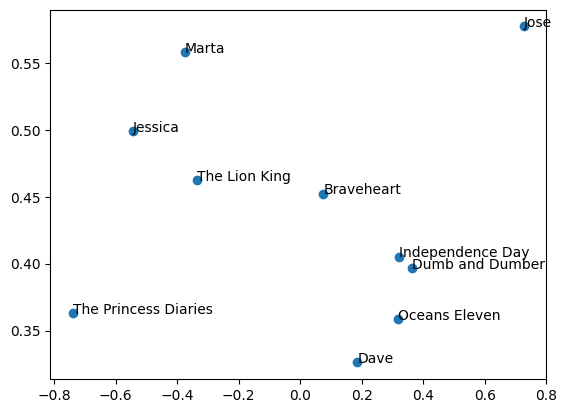

In [13]:
import matplotlib.pyplot as plt

xpoints = list(p[:,0]) + list(qt[0,:])
ypoints = list(p[:,1]) + list(qt[1,:])
labels = list(df['user'].unique()) + list(df['item'].unique())

fig, ax = plt.subplots()
ax.scatter(xpoints, ypoints)
for i, txt in enumerate(labels):
    ax.annotate(txt, (xpoints[i], ypoints[i]))

plt.show()

In [18]:
s_diagonal_matrix = np.diag(s)
prediction_matrix = np.dot(np.dot(p, s_diagonal_matrix), qt)
prediction_matrix

array([[4.65512129, 2.33990199, 4.3884088 , 3.20115056, 2.06495117,
        2.25998953],
       [4.38863558, 2.61697256, 4.5623114 , 3.77332824, 2.92680808,
        2.83390013],
       [0.95915358, 5.04025699, 3.046002  , 4.02382368, 4.00769263,
        4.91235533],
       [0.93479912, 0.06426001, 2.07343045, 3.03802843, 4.01227931,
        1.86009766]])

## FunkSVD

### Importar base de dados

In [15]:
import wget
!python3 -m wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
!tar -xvzf ml-20m-compact.tar.gz

100% [....................................................] 65019041 / 65019041
Saved under ml-20m-compact.tar (2).gz
dataset/
dataset/tags_sample.csv
dataset/._.DS_Store
dataset/.DS_Store
dataset/movies_sample.csv
dataset/._genome-tags.csv
dataset/genome-tags.csv
dataset/._ml-youtube.csv
dataset/ml-youtube.csv
dataset/._genome-scores.csv
dataset/genome-scores.csv
dataset/ratings_sample.csv


In [19]:
movies = pd.read_csv('./dataset/movies_sample.csv')
ratings = pd.read_csv('./dataset/ratings_sample.csv')
df = ratings[['userId', 'movieId', 'rating']]
df = df.merge(movies[['movieId', 'title']])
df

,userId,movieId,rating,title
0,11,7481,5.0,Enemy Mine (1985)
1,11,1046,4.5,Beautiful Thing (1996)
2,11,616,4.0,"Aristocats, The (1970)"
3,11,3535,2.0,American Psycho (2000)
4,11,5669,5.0,Bowling for Columbine (2002)
...,...,...,...,...
190616,138493,288,5.0,Natural Born Killers (1994)
190617,138493,1748,5.0,Dark City (1998)
190618,138493,616,4.0,"Aristocats, The (1970)"
190619,138493,1597,4.5,Conspiracy Theory (1997)


### Mapeamento de ids

In [ ]:
map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
map_items = {item: idx for idx, item in enumerate(df.movieId.unique())}
df['userId'] = df['userId'].map(ma,atp_users)
df['movieId'] = df['movieId'].map(map_items)
map_title = {}

for _, row in df.iterrows():
    map_title[row.movieId] = row.title


### Divisão da base em treino e teste

In [21]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=2)

### Treinamento do modelo

In [22]:
    def train_funksvd(train, n_factors, lr=0.05, reg=0.02, miter=10):
    global_mean = train['rating'].mean()
    n_users = df['userId'].max()+1
    n_items = df['movieId'].max()+1
    bu = np.zeros(n_users)
    bi = np.zeros(n_items)
    p = np.random.normal(0.1, 0.1, (n_users, n_factors))
    q = np.random.normal(0.1, 0.1, (n_items, n_factors))
    for f in range(n_factors):
        for t in range(miter):
            for index, row in train.iterrows():
                u = row['userId']
                i = row['movieId']
                r_ui = row['rating']
                pred = global_mean + bu[u] + bi[i] + np.dot(p[u], q[i])
                e_ui = r_ui - pred
                bu[u] = bu[u] + lr * e_ui - reg*bu[u]
                bi[i] = bi[i] + lr * e_ui - reg*bi[i]
                temp_uf = p[u][f]
                p[u][f] = p[u][f] + lr * (e_ui * q[i][f]   - reg * p[u][f])
                q[i][f] = q[i][f] + lr * (e_ui * temp_uf - reg * q[i][f])
    return global_mean, bu, bi, p, q

In [23]:
gl, bu, bi, p, q = train_funksvd(train, 2)

In [26]:
test.head()

,userId,movieId,rating,title
31477,729,11,5.0,Masters of the Universe (1987)
148621,7294,61,3.0,Dangerous Minds (1995)
25190,7646,9,3.0,Bachelor Party (1984)
91518,991,25,2.5,Keeping the Faith (2000)
113446,394,33,3.5,North by Northwest (1959)


In [97]:
pred = gl + bu[7646] + bi[9] + np.dot(p[7646], q[9])
pred

3.342541392403538

## SVD Otimizado

In [24]:
from math import sqrt

def train_svdopt(train, n_factors, lr=0.05, reg=0.02, miter=10):
    global_mean = train['rating'].mean()
    n_users = df['userId'].max()+1
    n_items = df['movieId'].max()+1
    bu = np.zeros(n_users)
    bi = np.zeros(n_items)
    p = np.random.normal(0.1, 0.1, (n_users, n_factors))
    q = np.random.normal(0.1, 0.1, (n_items, n_factors))
    error = []
    for t in range(miter):
        sq_error = 0
        for index, row in train.iterrows():
            u = row['userId']
            i = row['movieId']
            r_ui = row['rating']
            pred = global_mean + bu[u] + bi[i] + np.dot(p[u], q[i])
            e_ui = r_ui - pred
            sq_error = sq_error + pow(e_ui, 2)
            bu[u] = bu[u] + lr * e_ui
            bi[i] = bi[i] + lr * e_ui
            for f in range(n_factors):
                temp_uf = p[u][f]
                p[u][f] = p[u][f] + lr * (e_ui * q[i][f] - reg * p[u][f])
                q[i][f] = q[i][f] + lr * (e_ui * temp_uf - reg * q[i][f])
        error.append(sqrt(sq_error/len(train)))
    
    return global_mean, bu, bi, p, q, error

In [8]:
gl, bu, bi, p, q, error = train_svdopt(train, 2, miter=30)

NameError: name 'train_svdopt' is not defined

In [ ]:
plt.plot(error)
plt.show()

NameError: name 'plt' is not defined

In [113]:
test.head()

,userId,movieId,rating,title
31477,729,11,5.0,Masters of the Universe (1987)
148621,7294,61,3.0,Dangerous Minds (1995)
25190,7646,9,3.0,Bachelor Party (1984)
91518,991,25,2.5,Keeping the Faith (2000)
113446,394,33,3.5,North by Northwest (1959)


In [114]:
pred = gl + bu[991] + bi[25] + np.dot(p[991], q[25])
pred

3.836127475128757